<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/lsteffenel/ED-SNI-IntroDL/blob/main/02_Introduction_a_Keras_MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

## Construire un modèle de réseaux de neurones avec Keras

Keras est une bibliothèque "haut niveau" utilisée pour simplifier la description de modèles de réseaux de neurones sur Tensorflow (bibliothèque IA de Google). L'avantage surtout est de pouvoir utiliser des GPU pour accélérer le calcul.

Le travail avec Keras suit un cheminement similaires à celui avec Scikit-Learn, mais il y a quelques différences à retenir.

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import math
print (tf.__version__)


2.17.0


Dans le paragraphe suivant vous avez certainement eu un message d'erreur indiquant que vous n'avez pas des GPU. Dans ce cas, Keras utilisera la CPU de la machine.

## Chargement de données

Tout comme Scikit-Learn, Keras a aussi un ensemble de datasets prêt à utilisation pour des exemples. Dans le cas suivant, nous allons charger le dataset MNIST (écriture à la main) et le séparer en deux groupes : Train et Test. Les données de validation (vérification pendant l'entraînement) seront séparés du groupe Train plus tard.

In [49]:
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [50]:
x_train.shape
x_test.shape
y_test.shape

(10000,)

In [4]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Les données de MNIST se présentent sous la forme d'images 28x28 pixels, avec 256 tons de gris. Les labels (`y_train`, par exemple) correspondent aux caractères représentés : les chiffres 0 à 9.

Le paragraphe suivant définit une fonction permettant de visualiser ce dataset.

In [60]:
import random

def plot_images(x,y=None,y_pred=None):
  nrows=3
  ncols=4
  draw_labels = (y is not None)
  draw_pred   = (y_pred is not None)

  fig, axs = plt.subplots(nrows, ncols, layout=None)
  indices = random.sample(range(0,1000),nrows*ncols)
  i = 0
  for ax in axs.flat:
    ax.imshow(x[indices[i]])
    if not draw_labels and not draw_pred:
      ax.set_xlabel(indices[i], fontsize=12)
    if draw_labels and not draw_pred:
      ax.set_xlabel(y[indices[i]], fontsize=12)
    if draw_labels and draw_pred:
      pred = str(y_pred[indices[i]])+' ('+str(y[indices[i]])+')'
      ax.set_xlabel(pred, fontsize=12)
    i+=1
  plt.subplots_adjust(hspace=0.3)
  plt.tight_layout()
  plt.show()

Nous allons donc afficher l'un des caractères du groupe Train (celui à la position 27) mais aussi tout la plage entre les données 5 et 41. Remarquez le "label" correspondant sous chaque image.

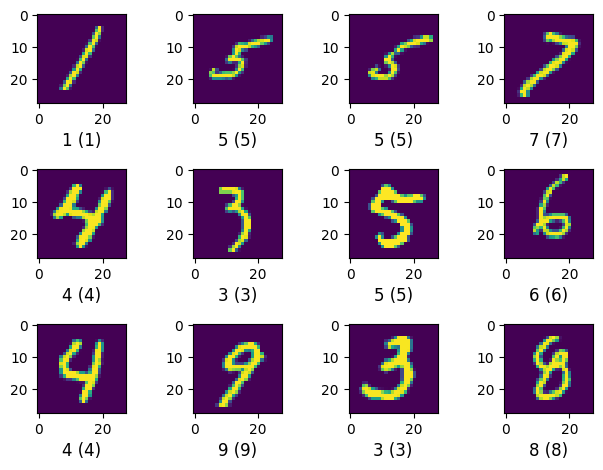

In [25]:
plot_images(x_train,y_train,y_train)

In [ ]:
plot_images(x_train, y_train, [27],  x_size=5,y_size=5, colorbar=True)
plot_images(x_train, y_train, range(5,41), columns=12)

Les paragraphes suivants font plusieurs opérations afin de préparer les données :

**1 - Reformater les données**

Les images 28x28 sont "applaties" en un seul array unidimensionnel de 784 valeurs

In [51]:
x_train = x_train.reshape(60000, 784) #  28*28
#x_test = x_test.reshape(10000, 784)

**2 - Transformation et normalisation des données**

Les valeurs de base son des entiers entre 0 et 255 pour représenter les 256 tons de gris. La majorité des algorithmes utilisent des valeurs réels, de préférence dans la fourchette 0 à 1 ou -1 à 1.

Les paragraphes suivantes modifient le type des données (`float32`) puis font une normalisation simple (diviser la valeur par 255). Bien sûr, d'autres méthodes de normalisation plus élaborées sont possibles, mais ça suffit pour l'instant.

In [27]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [28]:
x_train /= 255
x_test /= 255

**3 - Transformer les données catégoriques**
Lorsqu'on a des données catégoriques (texte ou numéros), il faut les transformer afin d'éviter des mauvaises compréhensions de la part de l'algorithme (par exemple, supposer que une classe 2 vient toujours après une classe 1). Dans notre cas, nous allons transformer les classes 0 à 9 en représentations numériques (similaire à HotOneEncoder de Sklearn), afin de rendre indépendantes ces classes.

In [29]:
from tensorflow.keras.utils import to_categorical

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [30]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## La Création d'un modèle

Keras a plusieurs modes permettant la création de modèles de réseaux de neurones. Dans ce cas, nous allons utiliser l'API `Sequential` qui permet de décrire couche par couche du réseau et les empiler (grâce à `add()`).

Nous allons faire un modèle simple avec des réseaux denses (totalement connectés). La première couche définit la taille de l'entrée (les 784 valeurs reçus du dataset), les autres utilisent par défaut la taille de la sortie de la couche précédente. Egalement, nous indiquons que chaque couche comptera avec 10 neurones.

Finalemen, remarquez qu'on utilise deux types de fonction d'activation, sigmoid et softmax.
Pour simplifier la description, sigmoid donne une probabilité entre 0 et 1, alors que Softmax affiche "1" sur la sortie avec la plus grande probabilité et "0" sur les autres. C'est pour cela qu'on utilise Softmax à la sortie, ça permet d'avoir un résultat plutôt qu'une liste de probabilités.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# Declaration du modèle en Tensorflow2.0
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(20, activation='sigmoid', input_dim =(784)))
model.add(tf.keras.layers.Dense(10, activation='sigmoid'))
model.add(tf.keras.layers.Dense(10, activation='sigmoid'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


# résumé du modèle
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │          15,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             110 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,130 (63.01 KB)

 Trainable params: 16,130 (63.01 KB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

Une fois défini le modèle, il faut l'entraîner avec les données.
Le paragraphe suivant définit les hyperparamètres du modèle, dont le `batch_size`(taille des sous-ensembles utilisés dans la descente de gradient), le nombre d'epochs (parcours de l'ensemble de données d'entraînement).

L'appel à compile indique aussi qu'on utilise le modèle de descente de gradient SGD (il y a plusieurs), que la métrique utilisée est l'accuracy (métrique qui correspond à (TP+TN)/(TP+TN+FP+FN)), et que la fonction de perte est la `categorical_crossentropy`, une fonction qui compare les probabilités pour des labels catégoriques.

In [32]:
batch_size = 100
#num_classes = 10
epochs= 20

model.compile(loss='categorical_crossentropy',  optimizer='SGD',  metrics=['accuracy'])


Finalement, on lance l'entraînement. Remarquez aussi qu'on n'a pas crée des données Validation avant, on le fera ici en réservant 10% des données de Train.

Comme le dataset est simple, on peut faire 50 epoch même sans un GPU.

In [33]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=1 )

#verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# Je vous invite à lire la documentation : https://keras.io/models/sequential/

Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1016 - loss: 2.3487 - val_accuracy: 0.1113 - val_loss: 2.3005
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1051 - loss: 2.3006 - val_accuracy: 0.1050 - val_loss: 2.2986
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1108 - loss: 2.2982 - val_accuracy: 0.1050 - val_loss: 2.2974
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1104 - loss: 2.2966 - val_accuracy: 0.1050 - val_loss: 2.2958
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1124 - loss: 2.2948 - val_accuracy: 0.1050 - val_loss: 2.2939
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1142 - loss: 2.2927 - val_accuracy: 0.1050 - val_loss: 2.2918
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1148 - loss: 2.2903 - val_accuracy: 0.1050 - val_loss: 2.2893
Epoch 8/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1123 - loss: 2.2884 - val_accuracy: 0.

Les paragraphes suivants nous permettent de voir comment le modèle améliore sa performance au fil des epochs

In [ ]:
def plot_history(history, figsize=(8,6),
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']}):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')

        plt.show()

In [ ]:
plot_history(history, figsize=(6,4))

Enfin, on peut estimer la performance du modèle avec les données Test.

Comparez ces valeur avec ceux de l'entraînement (`val_loss` et `val_accuracy``
 ci-dessus).

In [34]:
test_loss, test_acc = model.evaluate(x_test, y_test,verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 2.028909206390381
Test accuracy: 0.3037000000476837


Ces résultats montrent que le modèle se porte un peu moins bien avec de nouvelles données, mais ça reste intéressant.

## Exercice :
On a obtenu avec ce modèle basique, un taux d'accuracy d'environ 87%.
- Essayer d'améliorer la performence du modèle, en modifiant les fonctions d'activation, ou/et en n ajoutant le nombre de neurones et des couches intermédiaires.



In [57]:
# d'abord, on utilise le modèle pour faire une prévision sur l'ensemble de test
# Ça retourne une liste avec 10 colonnes (une par sortie possible).
y_sigmoid = model.predict(x_test.reshape(10000, 784))

# avec la fonction argmax, on ne garde que l'index de la colonne avec la plus grande valeur
y_pred    = np.argmax(y_sigmoid, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


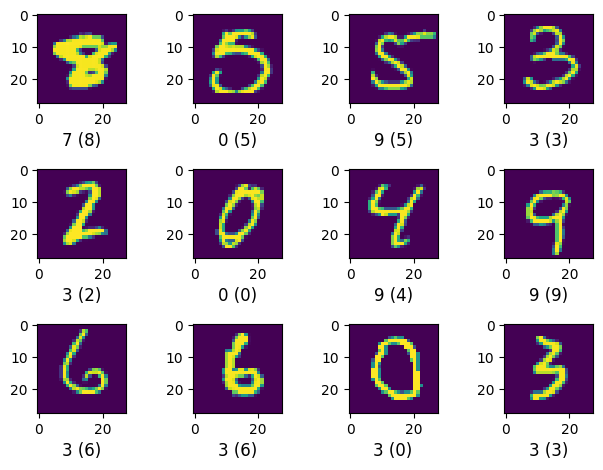

In [61]:
# maintenant, on affiche quelques éléments, avec la valeur prédite et la valeur attendue (entre parenthèses)
plot_images(x_test,y_test,y_pred)

## Bonus : Quelques exemples de fonctions d'activation de base



### Activation functions

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(-6, 6, 0.1)

### Linear  :  Fonction d'activation linéaire

C'est une fonction simple de la forme: f(x) = ax ou f(x) = x. En gros, l'entrée passe à la sortie sans une très grande modification ou alors sans aucune modification.

In [ ]:
def linear(x):
    a = []
    for item in x:
        a.append(item)
    return a

y = linear(x)

plt.plot(x,y)
plt.grid()
plt.show()


### Sigmoid

En mathématiques, la fonction sigmoïde (dite aussi courbe en S) est définie par :

$$ f(x)=\frac{1}{1 + e^{- x}}$$ pour tout réel x ;


Le but premier de la fonction est de réduire la valeur d'entrée pour la réduire entre 0 et 1. En plus d'exprimer la valeur sous forme de probabilité, si la valeur en entrée est un très grand nombre positif, la fonction convertira cette valeur en une probabilité de 1. A l'inverse, si la valeur en entrée est un très grand nombre négatif, la fonction convertira cette valeur en une probabilité de 0. D'autre part, l'équation de la courbe est telle que, seules les petites valeurs influent réellement sur la variation des valeurs en sortie.

La fonction Sigmoïde a plusieurs défaults:

- Elle n'est pas centrée sur zéro, c'est à dire que des entrées négatives peuvent engendrer des sorties positives.

- Etant assez plate, elle influe assez faiblement sur les neurones par rapport à d'autres fonctions d'activations. Le résultat est souvent très proche de 0 ou de 1 causant la saturation de certains neurones.

- Elle est couteuse en terme de calcul car elle comprend la fonction exponentielle.


In [ ]:
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/( (1+math.exp(-item) * 1)))
        # ici j'ai pri A = 1 : plus A est grand plus on se rapproche à la fonction echelon ...

    return a

y = sigmoid(x)

plt.plot(x,y)
plt.grid()
plt.show()


### Tahn :  Tangente Hyperbolique

Cette fonction ressemble à la fonction Sigmoïde. La différence avec la fonction Sigmoïde est que la fonction Tanh produit un résultat compris entre -1 et 1. La fonction Tanh est en terme général préférable à la fonction Sigmoïde car elle est centrée sur zéro. Les grandes entrées négatives tendent vers -1 et les grandes entrées positives tendent vers 1.

Mis à part cet avantage, la fonction Tanh possède les mêmes autres inconvénients que la fonction Sigmoïde.

In [ ]:
def tanh(x, derivative=False):
    if (derivative == True):
        return (1 - (x ** 2))
    return np.tanh(x)


y = tanh(x)

plt.plot(x,y)
plt.grid()
plt.show()

### ReLU : Unité de Rectification Linéaire
Pour résoudre le problème de saturation des deux fonctions précédentes (Sigmoïde et Tanh) il existe la fonction ReLU (Unité de Rectification Linéaire). Cette fonction est la plus utilisée.

La fonction ReLU est inteprétée par la formule: f(x) = max(0, x). Si l'entrée est négative la sortie est 0 et si elle est positive, alors la sortie est égale à x. Cette fonction d'activation augmente considérablement la convergence du réseau et ne sature pas.

Mais la fonction ReLU n'est pas parfaite. Si la valeur d'entrée est négative, le neurone reste inactif, ainsi les poids ne sont pas mis à jour et le réseau n’apprend pas.

In [ ]:
def relu(x):
    a = []
    for item in x:
        if item > 0:
            a.append(item)
        else:
            a.append(0)
    return a


y = relu(x)

plt.plot(x,y)
plt.grid()
plt.show()